# POSTPROCESSING MODULE

This notebook shows how to use the spiketoolkit.postprocessing module to:
1. compute spike waveforms
2. compute unit templates
3. compute unit maximum channel
4. compute pca scores
5. export sorted data to phy to curate the results
6. save curated sorting output

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import spikeextractors as se
import spiketoolkit as st
import spikewidgets as sw
import time
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as ss
%matplotlib notebook

20:52:14 [I] klustakwik KlustaKwik2 version 0.2.6
/afs/inf.ed.ac.uk/user/s17/s1727843/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


### Create toy example dataset

In [4]:
recording, sorting = se.example_datasets.toy_example(num_channels=4, duration=30, seed=0)

Assuming the `sorting` is the output of a spike sorter, the `postprocessing` module allows to extract all relevant information from the paired recording-sorting.

## 1) Compute spike waveforms

Waveforms are extracted with the `get_unit_waveforms` function by extracting snippets of the recordings when spikes are detected. When waveforms are extracted, the can be loaded in the `SortingExtractor` object as features. The ms before and after the spike event can be chosen. Waveforms are returned as a list of np.arrays (n_spikes, n_channels, n_points)

In [5]:
wf = st.postprocessing.get_unit_waveforms(recording, sorting, ms_before=1, ms_after=2, 
                                        save_as_features=True, verbose=True)

Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10


Now `waveforms` is a unit spike feature!

In [6]:
sorting.get_unit_spike_feature_names()
wf[0].shape

(76, 4, 90)

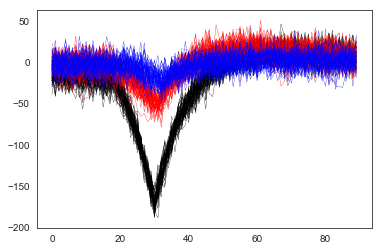

In [7]:
# plotting waveforms of units 0,1,2 on channel 0
plt.figure()
plt.plot(wf[0][:, 0, :].T, color='k', lw=0.3)
plt.plot(wf[1][:, 0, :].T, color='r', lw=0.3)
plt.plot(wf[2][:, 0, :].T, color='b', lw=0.3);

If the a certain property (e.g. `group`) is present in the RecordingExtractor, the waveforms can be extracted only on the channels with that property using the `grouping_property` and `compute_property_from_recording` arguments. For example, if channel [0,1] are in group 0 and channel [2,3] are in group 2, then if the peak of the waveforms is in channel [0,1] it will be assigned to group 0 and will have 2 channels and the same for group 1.

In [8]:
channel_groups = [[0, 1], [2, 3]]
for ch in recording.get_channel_ids():
    for gr, channel_group in enumerate(channel_groups):
        if ch in channel_group:
            recording.set_channel_property(ch, 'group', gr)
print(recording.get_channel_property(0, 'group'), recording.get_channel_property(2, 'group'))

0 1


In [9]:
wf_by_group = st.postprocessing.get_unit_waveforms(recording, sorting, ms_before=1, ms_after=2, 
                                                   save_as_features=False, verbose=True,
                                                   grouping_property='group', 
                                                   compute_property_from_recording=True)

# now waveforms will only have 2 channels
print(wf_by_group[0].shape)

Waveforms by property:  group
Waveform 1/10
Waveform 2/10
Waveform 3/10
Waveform 4/10
Waveform 5/10
Waveform 6/10
Waveform 7/10
Waveform 8/10
Waveform 9/10
Waveform 10/10
(76, 2, 90)


## 2) Compute unit templates (EAP)

Similarly to waveforms, templates - average waveforms - can be easily extracted using the `get_unit_templates`. When spike trains have numerous spikes, you can set the `max_num_waveforms` to be extracted. If waveforms have already been computd and stored as `features`, those will be used. Templates can be saved as unit properties.

In [10]:
templates = st.postprocessing.get_unit_template(recording, sorting, max_num_waveforms=200,
                                              save_as_property=True, verbose=True)

Using 'waveforms' features


In [11]:
sorting.get_unit_property_names()

['template']

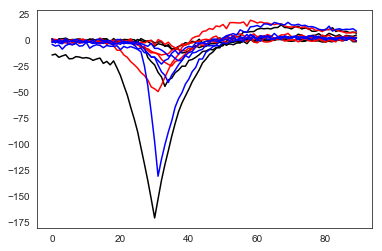

In [12]:
# plotting templates of units 0,1,2 on all four channels
plt.figure()
_ = plt.plot(templates[0].T, color='k')
_ = plt.plot(templates[1].T, color='r')
_ = plt.plot(templates[2].T, color='b')

## 3) Compute unit maximum channel

In the same way, one can get the ecording channel with the maximum amplitude and save it as a property.

In [13]:
max_chan = st.postprocessing.get_unit_max_channel(recording, sorting, save_as_property=True, verbose=True)
print(max_chan)

Using 'template' property
[0, 0, 1, 1, 1, 2, 2, 2, 2, 3]


In [14]:
sorting.get_unit_property_names()

['max_channel', 'template']

## 4) Compute pca scores

For some applications, for example validating the spike sorting output, PCA scores can be computed.


In [15]:
pca_scores = st.postprocessing.compute_pca_scores(recording, sorting, n_comp=3, verbose=True)

for pc in pca_scores:
    print(pc.shape)

Using 'waveforms' features
Fitting PCA of 3 dimensions on 713 waveforms
76
71
64
72
71
74
74
67
70
74
(76, 3)
(71, 3)
(64, 3)
(72, 3)
(71, 3)
(74, 3)
(74, 3)
(67, 3)
(70, 3)
(74, 3)


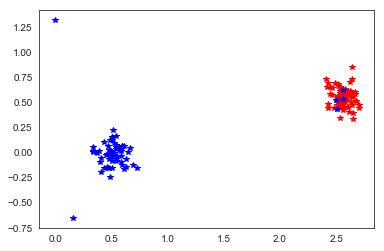

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pca_scores[0][:,0], pca_scores[0][:,1], 'r*')
ax.plot(pca_scores[2][:,0], pca_scores[2][:,1], 'b*')

PCA scores can be also computed electrode-wise. In the previous example, PCA was applied to the concatenation of the waveforms over channels. 

In [17]:
pca_scores_by_electrode = st.postprocessing.compute_pca_scores(recording, sorting, n_comp=3, by_electrode=True)

for pc in pca_scores_by_electrode:
    print(pc.shape)

304
284
256
288
284
296
296
268
280
296
(76, 4, 3)
(71, 4, 3)
(64, 4, 3)
(72, 4, 3)
(71, 4, 3)
(74, 4, 3)
(74, 4, 3)
(67, 4, 3)
(70, 4, 3)
(74, 4, 3)


In this case, as expected, 3 principal components are extracted for each electrode.

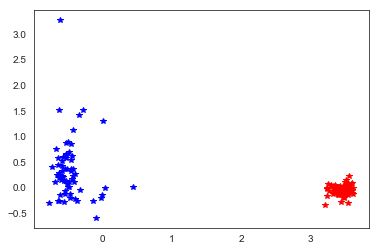

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pca_scores_by_electrode[0][:, 0, 0], pca_scores_by_electrode[0][:, 1, 0], 'r*')
ax.plot(pca_scores_by_electrode[2][:, 0, 0], pca_scores_by_electrode[2][:, 1, 1], 'b*')

## 5) Automatically Curate the sorted result

Before manually curating your dataset (which can be time intensive on large-scale recordings) it may be a good idea to perform
some automated curation of the sorted result.

Below is an example of two simple, automatic curation methods you can run:

In [19]:
snr_list = st.validation.qualitymetrics.compute_unit_SNR(recording, sorting)
print(snr_list)

[19.321362668787952, 7.1347723790248265, 14.572200165415367, 10.3590295291215, 9.113611937904054, 9.107864682851742, 15.293601899433895, 7.666255328235154, 5.831489483534372, 18.519676449363974]


In [20]:
curated_sorting1 = st.postprocessing.threshold_min_num_spikes(sorting=sorting, min_num_spike_threshold=70)
print("Unit spike train lengths uncurated: " + str([len(spike_train) for spike_train in [sorting.get_unit_spike_train(unit_id) for unit_id in sorting.get_unit_ids()]]))
print("Unit spike train lengths curated: " + str([len(spike_train) for spike_train in [curated_sorting1.get_unit_spike_train(unit_id) for unit_id in curated_sorting1.get_unit_ids()]]))

Unit spike train lengths uncurated: [76, 71, 64, 72, 71, 74, 74, 67, 70, 74]
Unit spike train lengths curated: [76, 71, 72, 71, 74, 74, 70, 74]


threshold_min_num_spikes automatically rejects any units with number of spikes lower than the given threshold. It returns a sorting extractor without those units

In [21]:
curated_sorting2 = st.postprocessing.threshold_min_SNR(recording=recording, sorting=curated_sorting1, min_SNR_threshold=6.0)
print("Unit SNRs uncurated: " + str(st.validation.qualitymetrics.compute_unit_SNR(recording, curated_sorting1)))
print("Unit SNRs curated: " + str(st.validation.qualitymetrics.compute_unit_SNR(recording, curated_sorting2)))

Unit SNRs uncurated: [19.321362668787952, 7.1347723790248265, 10.3590295291215, 9.113611937904054, 9.107864682851742, 15.293601899433895, 5.831489483534372, 18.519676449363974]
Unit SNRs curated: [19.321362668787952, 7.1347723790248265, 10.3590295291215, 9.113611937904054, 9.107864682851742, 15.293601899433895, 18.519676449363974]


threshold_min_SNR automatically rejects any units with SNR lower than the given threshold. It returns a sorting extractor without those units

## 6) Export sorted data to phy to manually curate the results

Finally, it is common to visualize and manually curate the data after spike sorting.
In order to do so, we interface wiht the Phy (https://phy-contrib.readthedocs.io/en/latest/template-gui/).

First, we need to export the data to the phy format:

In [24]:
sorting2 = se.CurationSortingExtractor(sorting)

In [28]:
sorting2.exclude_units(sorting2.get_unit_ids()[:-2])

In [29]:
sorting2.get_unit_ids()

[9, 10]

In [30]:
st.postprocessing.export_to_phy(recording, sorting2, output_folder='phy', verbose=True)

Changed number of PC to number of channels:  4
Using 'waveforms' features
Fitting PCA of 4 dimensions on 576 waveforms
280
295


ValueError: cannot reshape array of size 1180 into shape (74,4,4)

In [ ]:
!phy template-gui phy/params.py --debug

In this case, in phy, we manually merged to units. We can load back the curated data using the `PhysortingExtractor`:

In [ ]:
curated_sorting3 = se.PhySortingExtractor('phy/')

In [ ]:
print('Before manual curation: ', len(curated_sorting2.get_unit_ids()))
print('After manual curation: ', len(curated_sorting3.get_unit_ids()))

## 6) Save curated sorting output

The curated recordings can be either saved in any other format, or the PhySortingExtractor can be used reload the data from the phy format.

In [ ]:
se.MdaSortingExtractor.write_sorting(sorting=curated_sorting3, save_path='curated_results.mda')